# Preprocessing

In [1]:
import pandas as pd
df = pd.read_csv("data/train.csv")
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Dealing with missing data

### Keyword

In [2]:
print("Number of rows with null:")
df.apply(lambda x: sum(x.isnull()), axis='index')

Number of rows with null:


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

None have missing target (label) or text, which is good. We can use those without issues.

In [3]:
print('Num of Target 1 without keyword: ', df.query('target == 1 and keyword.isnull()').shape[0])
print('Num of Target 0 without keyword: ', df.query('target == 0 and keyword.isnull()').shape[0])

Num of Target 1 without keyword:  42
Num of Target 0 without keyword:  19


Whether or not the tweet is a disaster doesn't _really_ affect whether or not it has a keyword, and there won't be that many to fill in. So let's use the mode of each class to fill them in:

In [4]:
mode_0 = df[df.target == 0].keyword.mode().iloc[0]
mode_1 = df[df.target == 1].keyword.mode().iloc[0]

df['keyword'] = df.apply(
    lambda row: row.keyword if not pd.isna(row.keyword) else (mode_0 if row.target == 0 else mode_1),
    axis = 'columns' # apply to each row
)

## Location

In [5]:
print('Num of Target 1 without location: ', df.query('target == 1 and location.isnull()').shape[0])
print('Num of Target 0 without location: ', df.query('target == 0 and location.isnull()').shape[0])

Num of Target 1 without location:  1075
Num of Target 0 without location:  1458


There are quite a few missing for both targets, and the difference is large. Unfortunately we cannot do much with this, as predicting the location from other features (well, mainly the text) would be tough. So just replace nan values with an empty string.

In [6]:
df['location'] = df.apply(
    lambda row: row.location if not pd.isna(row.location) else '',
    axis = 'columns' # apply to each row
)

## Duplicates

In [7]:
print('Strict duplicates: ', df[df.duplicated()].size)
duplicated_text_rows = df[df.duplicated(['text'])]
print('Description duplicates: ', duplicated_text_rows.text.unique().size)
print('Number of duplicates with conflicting labels: ', duplicated_text_rows.apply(lambda onerow: df[onerow.text == df.text].target.unique().size == 1, axis='columns').value_counts()[False])

Strict duplicates:  0
Description duplicates:  69
Number of duplicates with conflicting labels:  37


In [8]:
n_removed = df.shape[0]-df.drop_duplicates(['text']).shape[0]
print('Number of dropped duplicate rows: ', n_removed)
print('As a percentage of total data: %.2f%%' % (float(n_removed)/df.shape[0]*100))
df = df.drop_duplicates(['text'])

Number of dropped duplicate rows:  110
As a percentage of total data: 1.44%


## Class imbalance

In [9]:
n_positive = df[df.target == 1].shape[0]
n_negative = df[df.target == 0].shape[0]
n_total = df.shape[0]
print(f'Positive: {n_positive} ({round(float(n_positive)/n_total*100, 2)}%)')
print(f'Negative: {n_negative} ({round(float(n_negative)/n_total*100, 2)}%)')

Positive: 3198 (42.62%)
Negative: 4305 (57.38%)


At the moment, we've determined this is not too bad.

# NLP

Set up the required imports, and load the data:

## Tailor the NLP pipeline to our purposes

Useful for reference:
* [rule-based matching](https://spacy.io/usage/rule-based-matching)
* [pipelines](https://spacy.io/usage/processing-pipelines)

Load up the base pipeline:

In [10]:
import spacy as spc
from spacy import displacy as dsp
nlp = spc.load("en_core_web_sm")

The first step is to make sure that '@' and '#' get the same treatment. By default, '@' is considered a part of a token, and '#' is considered its own token. So, make sure that they are considered individual tokens, to make processing easier in later parts.

In [11]:
prefixes = nlp.Defaults.prefixes + (r'@',r'#')
prefix_regex = spc.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

So, this is what the tokenizer does now:

In [12]:
for tok in nlp("@username text #hashtag"):
    print(tok)
    

@
username
text
#
hashtag


Next, define the part of the pipeline that combines the '@' and '#' symbols, followed by alphanumerics, into a single token:

In [13]:
def retokenize_pipe(doc):
    with doc.retokenize() as retokenizer:
        for tok in doc:
            if not tok.i == len(doc)-1:
                if (tok.text == '#' or tok.text == '@') and not (doc[tok.i+1].text == '#' or doc[tok.i+1].text == '@') and not bool(tok.whitespace_):
                    retokenizer.merge(doc[tok.i:tok.i+2])
                elif tok.text == '&' and not bool(tok.whitespace_) and not tok.i == len(doc)-1 and not '&' in [t.text for t in doc[tok.i+1:tok.i+3]]:
                    retokenizer.merge(doc[tok.i:tok.i+3])
    return doc

In some cases, the tweets contain HTML entities. Some should be replaced with their equivalent words like ('&' to 'and'), others should be removed/

In [14]:
def handle_htmlents_pipe(doc):
    replacements = {
        '&amp;': 'and',
        '&deg;': 'degrees',
        '%20': ' '
    }
    words = []
    has_space = []
    for t in doc:
        if t.text.startswith('&') and t.text.endswith(';'):
            if t.text in replacements:
                words.append(replacements[t.text])
                has_space.append(t.whitespace_)
        else:
            words.append(t.text)
            has_space.append(t.whitespace_)

    
    return spc.tokens.Doc(doc.vocab, words=words, spaces=has_space)

Certain mentions should be treated as special, i.e. if they mention an account belonging to a news/disaster relief organisation. The presence of such a handle would be a strong indicator of the tweet being about a disaster.

In [15]:
from json import load
with open('twitter_handles.json') as f:
    twitter_handles = load(f)

is_news_mention = lambda t: t.text.startswith('@') and t.text[1:].lower() in twitter_handles['news']
is_relief_mention = lambda t: t.text.startswith('@') and t.text[1:].lower() in twitter_handles['relief']
spc.tokens.Token.set_extension("is_news_mention", getter=is_news_mention, force=True)
spc.tokens.Token.set_extension("is_relief_mention", getter=is_relief_mention, force=True)

The extensions set above can be called with e.g. `Token._.is_news_mention`, they're not pipeline components. `force=True` is set because Jupyter would complain.

Then, the part of the pipeline which takes a '@xxxx' or '#xxx' symbol and marks it as the correct entity. Also marks links as link entities.

In [16]:
def entity_pipe(nlp):
    ruler = nlp.create_pipe("entity_ruler")
    
    patterns = [
        {"label": "HASHTAG", "pattern": [{"TEXT": {"REGEX": r'^#\w+'}}]},
        {"label": "LINK", "pattern": [{"TEXT": {"REGEX": r'https?://.*'}}]},
        {"label": "NEWS-ORG", "pattern": [{"_": {"is_news_mention": True}}]},
        {"label": "RELIEF-ORG", "pattern": [{"_": {"is_relief_mention": True}}]},
        {"label": "MENTION", "pattern": [{"TEXT": {"REGEX": r'^@\w+'}, "_": {"is_news_mention": False, "is_relief_mention": False}}]}
    ]
    
    ruler.add_patterns(patterns)
    return ruler

Some tweets include abbreviations, and these may get incorrectly classified by the default tools. This part of the pipeline should fix that.

In [17]:
def abbr_handler(nlp):
    ruler = nlp.create_pipe("entity_ruler")
    patterns = [
        {"label": "ORG", "pattern": [{"LOWER": {"REGEX": r'e\.?r\.?'}}]},
        {"label": "ORG", "pattern": [{"LOWER": "emergency"}, {"LOWER": "room"}]},
        {"label": "ORG", "pattern": [{"LOWER": "emergency"}, {"LOWER": "relief"}]}
    ]
    ruler.add_patterns(patterns)
    return ruler

Insert the functions into the NLP pipeline. The tokenizer is the first thing that runs (implicitly, it's not visible in the pipeline), so the token combiner function should be the first thing in the pipeline. The entity ruler should go before the named entity recogniser, as we want the NER to recognise anything that our custom ruler doesn't recognise, not the other way around.

In [18]:
nlp.add_pipe(retokenize_pipe, name="retokenizer", first=True)
nlp.add_pipe(handle_htmlents_pipe, name="html_ent_handler", after='retokenizer')
nlp.add_pipe(entity_pipe(nlp), name="entruler", before='ner')
nlp.add_pipe(abbr_handler(nlp), name="abbr_handler", after='ner')

The current pipeline looks like this:

In [19]:
nlp.pipeline

[('retokenizer', <function __main__.retokenize_pipe(doc)>),
 ('html_ent_handler', <function __main__.handle_htmlents_pipe(doc)>),
 ('tagger', <spacy.pipeline.pipes.Tagger at 0x11fcbed10>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x11fb64a60>),
 ('entruler', <spacy.pipeline.entityruler.EntityRuler at 0x126d6cd90>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x11fb64520>),
 ('abbr_handler', <spacy.pipeline.entityruler.EntityRuler at 0x126d6ce50>)]

## Execute the pipeline

Now, run the pipeline on a random tweet:

In [20]:
random_tweet = df.sample().iloc[0].text
doc = nlp(random_tweet)

The tweet has been tokenized, but not all tokens are useful. In particular, stop words and punctuation are useless for us, so `is_token_allowed` will filter those out:

In [21]:
def is_token_allowed(token):
    return (token and token.string.strip() and not token.is_stop and not token.is_punct)

We also only want some entities:

In [22]:
def is_entity_allowed(entity):
    wanted = ['NEWS-ORG', 'RELIEF-ORG', 'HASHTAG', 'ORG', 'GPE', 'FAC', 'MENTION']
    return entity.label_ in wanted

Also, all tokens should be converted to their lowercase, lemmatized form.
So, define two functions:

In [23]:
def get_useful_tokens(doc):
    return [{'token': token.lemma_.strip().lower(), 'pos': token.pos_, 'dep': token.dep_, 'ent': token.ent_type_} 
             for token in doc 
             if is_token_allowed(token)]

def get_useful_ents(doc):
    return [{'text': ent.text, 'label': ent.label_} 
            for ent in doc.ents 
            if is_entity_allowed(ent)]

Extract tokens with specific properties to get the general idea of the sentence:

In [24]:
def extract_sov(toks):
    subjects = list({t['token'] for t in toks if t['dep'] in ['nsubj', 'nsubjpass'] and t['ent'] not in ['LINK', 'MENTION', 'HASHTAG', 'RELIEF-ORG', 'NEWS-ORG']})
    objects = list({t['token'] for t in toks if t['dep'] in ['dobj', 'obj', 'pobj'] and t['ent'] not in ['LINK', 'MENTION', 'HASHTAG', 'RELIEF-ORG', 'NEWS-ORG']})
    verbs = list({t['token'] for t in toks if t['pos'] in ['VERB'] and t['ent'] not in ['LINK', 'MENTION', 'HASHTAG', 'RELIEF-ORG', 'NEWS-ORG']})

    return subjects, objects, verbs

We'll want to filter the list of entities for a specific label, so define a helper function:

In [25]:
def select_ents_by_label(label, ent_list, text_only=False):
    return [(ent['text'] if text_only else ent)
            for ent in ent_list
            if ent['label'] == label]

We want to figure out if the entities a tweet contains include known news/relief organisations:

In [26]:
def contains_news_mention(ent_list):
    return bool(select_ents_by_label('NEWS-ORG', ent_list))

def contains_relief_mention(ent_list):
    return bool(select_ents_by_label('RELIEF-ORG', ent_list))

## Process the dataset

Next, create a new dataframe and run the pipeline + aux functions on the whole training dataset.

In [27]:
df_out = pd.DataFrame(columns=['id', 'keyword', 'location', 'text', 'hashtag', 'hashtags_have_l1_synonyms', 'hashtags_have_l2_synonyms', 'subj', 'verb', 'obj', 'contains_l1_synonyms', 'contains_l2_synonyms', 'contains_damaged_words', 'mentioned_news_org', 'mentioned_relief_org', 'mentions', 'orgs', 'gpes', 'facs', 'target'])

from tqdm.notebook import tqdm
for i, twit in tqdm(df.iterrows(), total=df.shape[0], desc="Feature extraction"):
    doc = nlp(twit.text)
    useful_tokens = get_useful_tokens(doc)
    useful_entities = get_useful_ents(doc)
    
    subjs, objs, verbs = extract_sov(useful_tokens)
    
    l1_synonyms = {'accident', 'accidentally', 'accidental', 
                   'terrible', 'terribly',
                   'unfortunate',
                   'calamity', 'cµµalamitous', 
                   'catastrophe', 'catastrophic', 'catastrophically', 
                   'collapse', 
                   'crash', 
                   'debacle', 
                   'defeat',
                   'drown',
                   'emergency', 
                   'failure', 
                   'fiasco', 
                   'flood', 
                   'harm', 'harmful', 'harmfully', 
                   'hazard', 'hazardous', 'hazardously', 
                   'holocaust', 
                   'mishap', 
                   'setback', 
                   'tragedy', 'tragic', 'tragically'}
    l2_synonyms = {'adversity', 'adverse', 'adversely', 
                   'affliction', 
                   'bale', 
                   'bane', 
                   'blight', 
                   'blow', 
                   'bust', 
                   'casualty', 
                   'cataclysm', 'cataclysmic', 'cataclysmically', 
                   'collision', 
                   'depression', 
                   'exigency', 
                   'fall', 
                   'flop', 
                   'grief', 
                   'misadventure', 
                   'mischance', 
                   'misfortune', 
                   'reverse',
                   'rock', 
                   'rough', 
                   'ruin', 'ruination', 
                   'slip', 
                   'stroke', 
                   'undoing', 
                   'upset', 
                   'woe', 'woeful', 'woefully', 
                   'sad', 'sadness', 'sadly'}
    
    contains_l1_synonyms = 0 < len(l1_synonyms.intersection({x['token'] for x in useful_tokens}))
    contains_l2_synonyms = 0 < len(l2_synonyms.intersection({x['token'] for x in useful_tokens}))
    hashtags_have_l1_synonyms = 0 < len(l1_synonyms.intersection({x[1:] for x in select_ents_by_label('HASHTAG', useful_entities, text_only=True)}))
    hashtags_have_l2_synonyms = 0 < len(l2_synonyms.intersection({x[1:] for x in select_ents_by_label('HASHTAG', useful_entities, text_only=True)}))
    
    damaged_words = {
        'crack',
        'rupture',
        'fissure',
        'burn',
        'combust',
        'explode', 'explosion',
        'implode', 'implosion',
        'corrode', 'corrosion',
        'rust',
        'flood',
        'pollute', 'pollution',
        'radioactive', 'radioactivity',
        'meltdown',
        'splinter',
        'disintegrate',
        'collapse',
        'sink',
        'shatter',
        'bruise'
    } # ways in which shit can be broken
    
    contains_damaged_words = 0 < len(damaged_words.intersection({x['token'] for x in useful_tokens}))
    
    df_out.loc[i] = {
        'id': twit.id,
        'keyword': twit.keyword,
        'location': twit.location,
        'text': twit.text,
        'hashtag': select_ents_by_label('HASHTAG', useful_entities, text_only=True),
        'hashtags_have_l1_synonyms': hashtags_have_l1_synonyms,
        'hashtags_have_l2_synonyms': hashtags_have_l2_synonyms,
        'subj': subjs,
        'verb': verbs,
        'obj': objs,
        'mentioned_news_org': contains_news_mention(useful_entities),
        'mentioned_relief_org': contains_relief_mention(useful_entities),
        'mentions': select_ents_by_label('MENTION', useful_entities, text_only=True),
        'contains_l1_synonyms': contains_l1_synonyms,
        'contains_l2_synonyms': contains_l2_synonyms,
        'contains_damaged_words': contains_damaged_words,
        'orgs': select_ents_by_label('ORG', useful_entities, text_only=True),
        'gpes': select_ents_by_label('GPE', useful_entities, text_only=True),
        'facs': select_ents_by_label('FAC', useful_entities, text_only=True),
        'target': twit.target
    }

In [28]:
df_out.columns

Index(['id', 'keyword', 'location', 'text', 'hashtag',
       'hashtags_have_l1_synonyms', 'hashtags_have_l2_synonyms', 'subj',
       'verb', 'obj', 'contains_l1_synonyms', 'contains_l2_synonyms',
       'contains_damaged_words', 'mentioned_news_org', 'mentioned_relief_org',
       'mentions', 'orgs', 'gpes', 'facs', 'target'],
      dtype='object')

Replace empty lists with a placeholder:

In [47]:
df_out = df_out.applymap(lambda cell: ['_'] if (type(cell) == list and len(cell) == 0) else cell)

Export the extracted features dataframe to a parquet file:

In [48]:
df_out.to_parquet("features.parquet")

# Feature selection

General statistics about the features:

In [30]:
num_total = df_out.shape[0]
def pct_with_value_for_col(column_name, df):
    try:
        num = df_out[column_name].map(bool).value_counts()[True]
        return round(float(num)/num_total*100, 2)
    except KeyError:
        return 0

print("Percentage of dataset with values for the specified columns:")
for col in df_out.columns:
    if col not in ['id', 'text', 'target']:
        print(f"Value for {col}: {pct_with_value_for_col(col, df)}%")

Percentage of dataset with values for the specified columns:
Value for keyword: 100.0%
Value for location: 66.92%
Value for hashtag: 22.44%
Value for hashtags_have_l1_synonyms: 0.12%
Value for hashtags_have_l2_synonyms: 0.03%
Value for subj: 52.9%
Value for verb: 79.23%
Value for obj: 79.39%
Value for contains_l1_synonyms: 12.58%
Value for contains_l2_synonyms: 5.1%
Value for contains_damaged_words: 8.0%
Value for mentioned_news_org: 0.95%
Value for mentioned_relief_org: 0.04%
Value for mentions: 25.4%
Value for orgs: 59.72%
Value for gpes: 15.19%
Value for facs: 1.73%


Is the location being present an indication of the tweet relating to a disaster?
Not really.

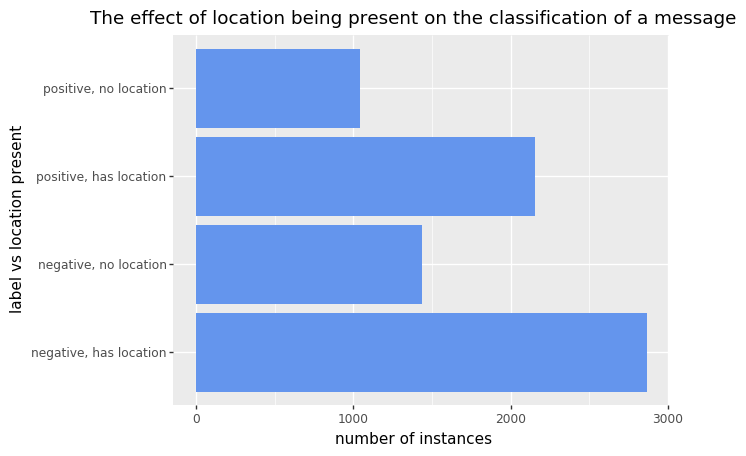

<ggplot: (312187117)>


In [31]:
import plotnine as p9
allplots = [] # for safekeeping

def addplot(plt):
    allplots.append(plt)
    print(plt)
    
combinations = [['positive, has location', 'target == 1 and location != ""'], 
                ['positive, no location', 'target == 1 and location == ""'],
                ['negative, has location', 'target == 0 and location != ""'], 
                ['negative, no location', 'target == 0 and location == ""']]

addplot(p9.ggplot(pd.DataFrame({'features': [x[0] for x in combinations],
                                'count': [df_out.query(x[1]).shape[0] for x in combinations]},
                               columns=['features', 'count']))
        + p9.aes(x='features', y='count')
        + p9.geom_col(fill='cornflowerblue')
        + p9.ylab("number of instances")
        + p9.xlab("label vs location present")
        + p9.ggtitle("The effect of location being present on the classification of a message")
        + p9.coord_flip()
       )

For the few rows that mention news org, does it mean they're a disaster tweet?

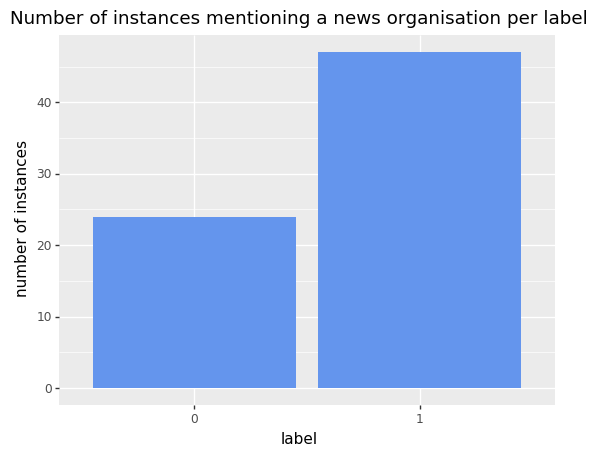

<ggplot: (329088701)>


In [32]:
addplot(p9.ggplot(df_out[df_out.mentioned_news_org])
        + p9.aes(x='target')
        + p9.xlab('label')
        + p9.ylab('number of instances')
        + p9.geom_bar(fill='cornflowerblue')
        + p9.ggtitle("Number of instances mentioning a news organisation per label")
       )

Same with relief org, if they mention one, is it a disaster tweet?

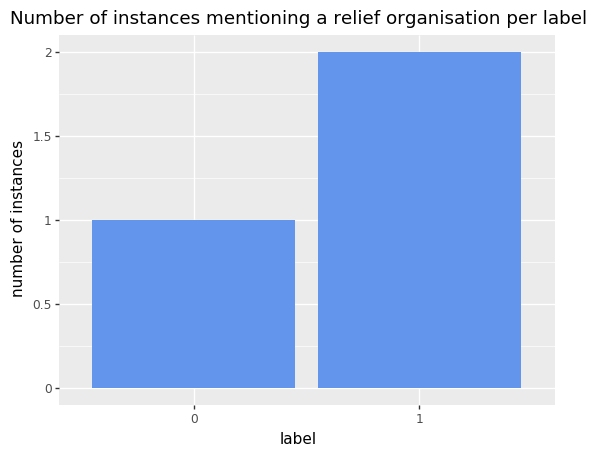

<ggplot: (313767513)>


In [33]:
addplot(p9.ggplot(df_out[df_out.mentioned_relief_org])
        + p9.aes(x='target')
        + p9.xlab('label')
        + p9.ylab('number of instances')
        + p9.geom_bar(fill='cornflowerblue')
        + p9.ggtitle("Number of instances mentioning a relief organisation per label")
       )

What about the correlation between containing a synonym for 'disaster' and being a tweet _about_ a disaster?

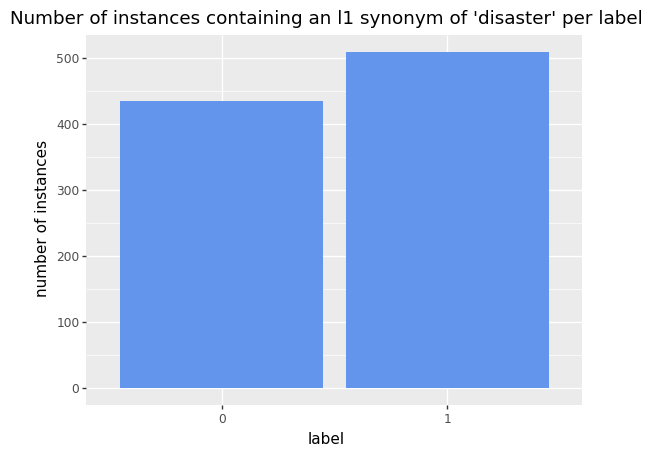

<ggplot: (298649621)>


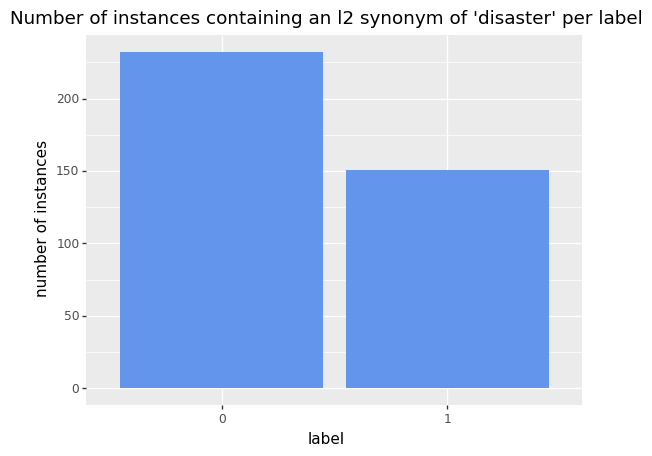

<ggplot: (298775533)>


In [34]:
addplot(p9.ggplot(df_out[df_out.contains_l1_synonyms])
        + p9.aes(x='target')
        + p9.xlab('label')
        + p9.ylab('number of instances')
        + p9.geom_bar(fill='cornflowerblue')
        + p9.ggtitle("Number of instances containing an l1 synonym of 'disaster' per label")
       )
addplot(p9.ggplot(df_out[df_out.contains_l2_synonyms])
        + p9.aes(x='target')
        + p9.xlab('label')
        + p9.ylab('number of instances')
        + p9.geom_bar(fill='cornflowerblue')
        + p9.ggtitle("Number of instances containing an l2 synonym of 'disaster' per label")
       )

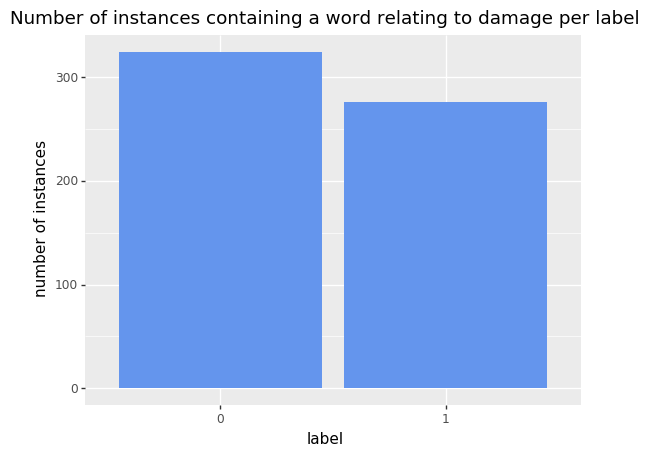

<ggplot: (298665797)>


In [35]:
addplot(p9.ggplot(df_out[df_out.contains_damaged_words])
        + p9.aes(x='target')
        + p9.xlab('label')
        + p9.ylab('number of instances')
        + p9.geom_bar(fill='cornflowerblue')
        + p9.ggtitle("Number of instances containing a word relating to damage per label")
       )

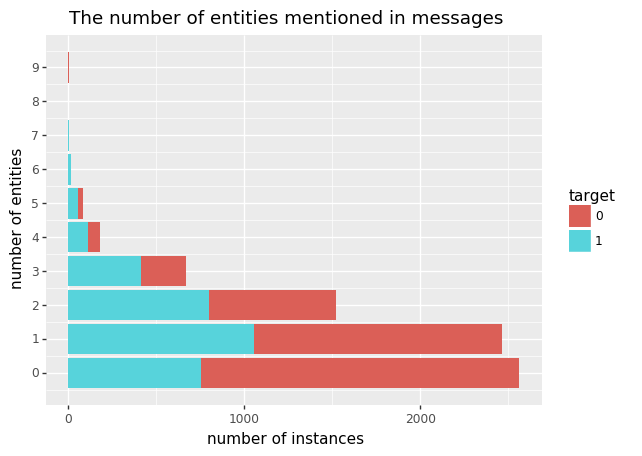

<ggplot: (298659945)>


In [36]:
plotdf = pd.DataFrame(columns=['num_ents', 'target'])
plotdf['num_ents'] = df_out.apply(lambda x: len(x.orgs)+len(x.gpes)+len(x.facs), axis='columns')
plotdf.target = df_out.target

addplot(p9.ggplot(plotdf)
        + p9.aes(x='num_ents', fill='target')
        + p9.xlab('number of entities')
        + p9.ylab('number of instances')
        + p9.geom_bar()
        + p9.scale_x_continuous(breaks=range(0,plotdf.num_ents.max()+1))
        + p9.coord_flip()
        + p9.ggtitle("The number of entities mentioned in messages")
       )


It looks a _bit_ like the disaster tweets have more entities.

What about the number of hashtags?

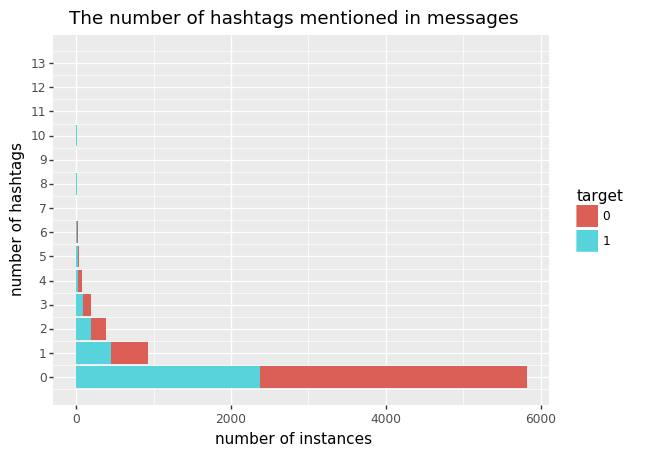

<ggplot: (298777997)>


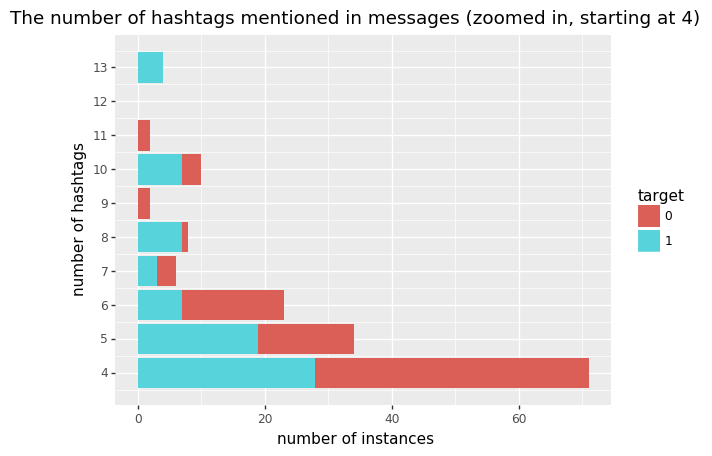

<ggplot: (298785617)>


In [37]:
plotdf = pd.DataFrame(columns=['num_hashtags', 'target'])
plotdf['num_hashtags'] = df_out.apply(lambda x: len(x.hashtag), axis='columns')
plotdf.target = df_out.target


addplot(p9.ggplot(plotdf)
        + p9.aes(x='num_hashtags', fill='target')
        + p9.geom_bar()
        + p9.xlab('number of hashtags')
        + p9.ylab('number of instances')
        + p9.scale_x_continuous(breaks=range(0,plotdf.num_hashtags.max()+1))
        + p9.coord_flip()
        + p9.ggtitle("The number of hashtags mentioned in messages")
       )
      

addplot(p9.ggplot(plotdf[plotdf.num_hashtags >= 4])
        + p9.aes(x='num_hashtags', fill='target')
        + p9.geom_bar()
        + p9.xlab('number of hashtags')
        + p9.ylab('number of instances')
        + p9.scale_x_continuous(breaks=range(4,plotdf.num_hashtags.max()+1))
        + p9.coord_flip()
        + p9.ggtitle("The number of hashtags mentioned in messages (zoomed in, starting at 4)")
       )

It looks like disaster tweets seem to have more hashtags in general. Though it's a bit hard to say, because e.g. 9 and 11 hashtags means that the tweet is not about a disaster, for some reason.

# Appendix: useful functions

Extract all mentions from the dataframe into a text file for further processing/analyzing:

```python
with open('mentions.txt', "w") as f:
    for i,content in df_out[df_out.mentions.map(bool)].iterrows():
        [f.write("%s\n" % x) for x in content.mentions]
``` 